# Feature Extraction for Skin Disease

In [ ]:
# How many images in our folder
import os

# Walk through 10 percent data directory and list number of file
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

## Create data loaders

In [31]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/train'
test_dir = '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/test'

train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

print('Training images:')
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

print('Testing images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 120 images belonging to 2 classes.
Testing images:
Found 30 images belonging to 2 classes.


## Setting up callbacks

In [32]:
# Create TensorBoard callback (functionize because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to: {log_dir}')

  return tensorboard_callback

## Create a Model

In [33]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficient_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [34]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 

In [35]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=10):
  '''
  Returns:
  An uncompiled Keras Sequenctial model with model_url as feature extractor 
  layer and Dense outpul layer with num_classes output neurons.
  '''

  # Download the pretrained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # feaze the already learned patterns
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])

  return model

## Creating ResNet TensorFlow Hub Feature Extraction model

In [36]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)

In [37]:
# Compile the ResNet model
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [38]:
train_data

In [39]:
# Fit the model
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                           experiment_name='resnet50V2')])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20230131-012252
Epoch 1/5
4/4 [==============================] - 34s 8s/step - loss: 0.7321 - accuracy: 0.5917 - val_loss: 0.6804 - val_accuracy: 0.6000
Epoch 2/5
4/4 [==============================] - 22s 6s/step - loss: 0.5223 - accuracy: 0.8000 - val_loss: 0.4764 - val_accuracy: 0.7000
Epoch 3/5
4/4 [==============================] - 21s 5s/step - loss: 0.4435 - accuracy: 0.8167 - val_loss: 0.4313 - val_accuracy: 0.7333
Epoch 4/5
4/4 [==============================] - 20s 5s/step - loss: 0.3575 - accuracy: 0.8417 - val_loss: 0.5563 - val_accuracy: 0.6333
Epoch 5/5
4/4 [==============================] - 23s 6s/step - loss: 0.3169 - accuracy: 0.8833 - val_loss: 0.5594 - val_accuracy: 0.6000


In [40]:
# Let's create a function to plot the loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure()
  plt.plot(epochs,loss,label='Training_loss')
  plt.plot(epochs,val_loss,label='Val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot Accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='Training_accuracy')
  plt.plot(epochs,val_accuracy,label='Val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

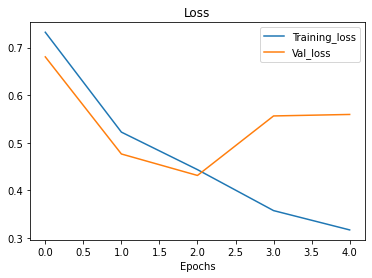

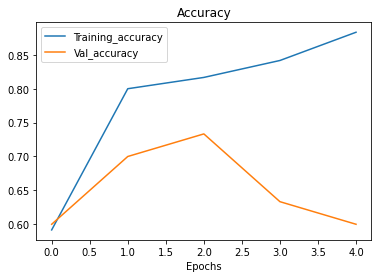

In [41]:
plot_loss_curves(history_resnet)

## Creating EfficientNetB0 TensorFlow Hub Feature Extraction model

In [42]:
# Create EfficienetB0 feature extraction model
efficientnet_model = create_model(model_url=efficient_url,
                                  num_classes=train_data.num_classes)

# Compile the model
efficientnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# Fit the model
history_efficientnet = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                        experiment_name='efficientnetB0')]
                                              )

Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/20230131-013606


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/5
4/4 [==============================] - 22s 3s/step - loss: 0.8166 - accuracy: 0.4750 - val_loss: 0.7327 - val_accuracy: 0.5667
Epoch 2/5
4/4 [==============================] - 11s 3s/step - loss: 0.6577 - accuracy: 0.6083 - val_loss: 0.5999 - val_accuracy: 0.6667
Epoch 3/5
4/4 [==============================] - 10s 2s/step - loss: 0.5877 - accuracy: 0.6917 - val_loss: 0.5755 - val_accuracy: 0.6667
Epoch 4/5
4/4 [==============================] - 11s 3s/step - loss: 0.5342 - accuracy: 0.7583 - val_loss: 0.6079 - val_accuracy: 0.6667
Epoch 5/5
4/4 [==============================] - 11s 3s/step - loss: 0.4725 - accuracy: 0.8333 - val_loss: 0.6426 - val_accuracy: 0.6667


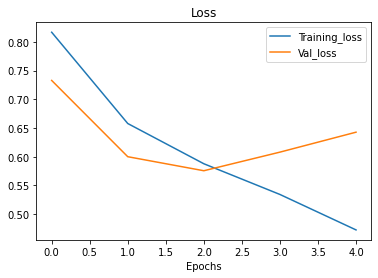

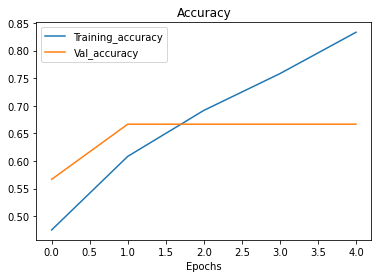

In [43]:
plot_loss_curves(history_efficientnet)

## Comparing our models results using TensorBoard

In [44]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name 'EfficientNetB0 vs. ResNet50V2' \
  --description 'Comparing two diffrent TF....' \
  --one_shot

2023-01-31 01:42:43.961995: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%

# Fine Tuning ( Feature Extraction )

## Import helper functions

In [45]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-31 02:00:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-31 02:00:13 (58.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [46]:
# Import helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

## Import Data

In [50]:
# Check out how many images and subdirectories are in our datasets
walk_through_dir('/content/drive/MyDrive/Tensorflow_Certificate/dataset2')

There are 3 directories and 1 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2'.
There are 2 directories and 1 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/validation'.
There are 0 directories and 15 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/validation/Basal cell carcinoma'.
There are 0 directories and 15 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/validation/Melanoma'.
There are 2 directories and 1 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/train'.
There are 0 directories and 63 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/train/Melanoma'.
There are 0 directories and 62 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/train/Carcinoma'.
There are 2 directories and 1 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/test'.
There are 0 directories and 18 images in '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/test/Melan

In [51]:
# Create training and test directory paths
train_dir = '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/train'
test_dir = '/content/drive/MyDrive/Tensorflow_Certificate/dataset2/test'

In [66]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 120 files belonging to 2 classes.
Found 30 files belonging to 2 classes.


In [69]:
# Check out the class names of our dataset
train_data.class_names,test_data.class_names

(['Carcinoma', 'Melanoma'], ['Carcinoma', 'Melanoma'])

In [56]:
# See an example of a batch of data
for images,labels in train_data.take(1):
  print(images,labels)

tf.Tensor(
[[[[189.35085  128.39285   79.11607 ]
   [190.03365  128.00893   78.590645]
   [186.       122.37947   71.93327 ]
   ...
   [184.44615  167.44615  132.44615 ]
   [183.0893   166.0893   131.0893  ]
   [180.69647  163.69647  128.69647 ]]

  [[188.63704  127.68853   76.27336 ]
   [191.08037  128.14557   77.61296 ]
   [187.44571  122.34822   72.54839 ]
   ...
   [184.2002   167.2002   132.2002  ]
   [182.63704  165.63704  130.63704 ]
   [180.69647  163.69647  128.69647 ]]

  [[187.78993  126.00446   74.00446 ]
   [189.28053  125.84893   75.21875 ]
   [189.84048  123.15952   74.      ]
   ...
   [184.48218  167.48218  132.48218 ]
   [182.       165.       130.      ]
   [180.90651  163.90651  128.90651 ]]

  ...

  [[164.29933  105.51388   66.29935 ]
   [157.3825    99.10197   58.012684]
   [157.96428   99.96429   56.964287]
   ...
   [194.6284   135.6284    77.628395]
   [193.82307  134.82307   76.79557 ]
   [186.3302   127.33019   69.33019 ]]

  [[162.74207  104.0312    64.7420

## Model 0: Functional API

In [70]:
from tensorflow.python import train
# 1. Create a model with keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. If using a model like ResNet50V02 you will need to normalize inputs (No need for EfficientNets)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information,reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(2,activation='softmax',name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# 10. Fit the model
history_0 = model_0.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = int(len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                 experiment_name='skin_disease_feature_extraction')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/skin_disease_feature_extraction/20230131-023127
Epoch 1/5
4/4 [==============================] - 18s 3s/step - loss: 0.7485 - accuracy: 0.5250 - val_loss: 0.7656 - val_accuracy: 0.6000
Epoch 2/5
4/4 [==============================] - 10s 2s/step - loss: 0.6275 - accuracy: 0.6500 - val_loss: 0.8204 - val_accuracy: 0.5333
Epoch 3/5
4/4 [==============================] - 10s 2s/step - loss: 0.5652 - accuracy: 0.7333 - val_loss: 0.8134 - val_accuracy: 0.5333
Epoch 4/5
4/4 [==============================] - 10s 2s/step - loss: 0.4908 - accuracy: 0.8000 - val_loss: 0.8088 - val_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 10s 2s/step - loss: 0.4698 - accuracy: 0.7917 - val_loss: 0.8293 - val_accuracy: 0.4333


In [71]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.8293 - accuracy: 0.4333


[0.8293459415435791, 0.4333333373069763]

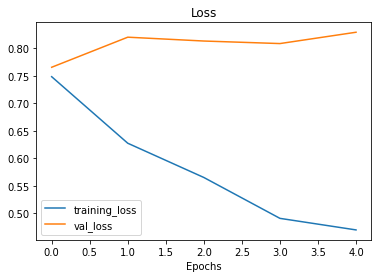

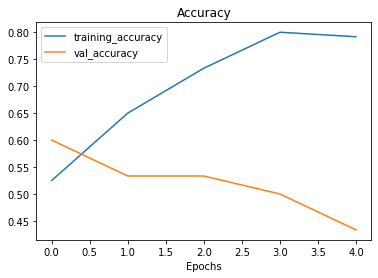

In [72]:
# Check out our model's training curves
plot_loss_curves(history_0)

In [59]:
# Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 tf.math.truediv_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [60]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [61]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


## Model 1: Adding Data Augmentation

In [73]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # No need since we are using effiecientNet
],name='augmentation')


# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape,name='input_layer')
x = data_augmentation(inputs)
x = base_model(x,training=False) # pass the augmentated images to the base model but keep it in inference mode
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(2,activation='softmax',name='output_layer')(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [75]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_____________________________________________

### Create a Model Checkpoint Callback

In [76]:
# Set Checkpoint paths
checkpoint_path = 'skin_disease_model_checkpoints_weights/checkpoints.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save ever epoch
                                                         verbose=1)

### Fit the model

In [78]:
#Fit the model
initial_epochs = 5
history_1 = model_1.fit(train_data,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps = int(len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                 experiment_name='skin_disease_data_aug'),
                                     checkpoint_callback]
                        )

Saving TensorBoard log files to: transfer_learning/skin_disease_data_aug/20230131-024138
Epoch 1/5
4/4 [==============================] - ETA: 0s - loss: 0.7243 - accuracy: 0.5667
Epoch 1: saving model to skin_disease_model_checkpoints_weights/checkpoints.ckpt
4/4 [==============================] - 22s 3s/step - loss: 0.7243 - accuracy: 0.5667 - val_loss: 0.7546 - val_accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.6250
Epoch 2: saving model to skin_disease_model_checkpoints_weights/checkpoints.ckpt
4/4 [==============================] - 15s 3s/step - loss: 0.6688 - accuracy: 0.6250 - val_loss: 0.6947 - val_accuracy: 0.5333
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6917
Epoch 3: saving model to skin_disease_model_checkpoints_weights/checkpoints.ckpt
4/4 [==============================] - 11s 3s/step - loss: 0.6166 - accuracy: 0.6917 - val_loss: 0.6875 - val_accuracy: 0.5667
Epoch 4/5
4/4 

In [79]:
# What were model_0 results?
model_0.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.8293 - accuracy: 0.4333


[0.8293460011482239, 0.4333333373069763]

In [80]:
# Check model_1 results
skin_disease_data_aug = model_1.evaluate(test_data)
skin_disease_data_aug

1/1 [==============================] - 2s 2s/step - loss: 0.6488 - accuracy: 0.6000


[0.6487987041473389, 0.6000000238418579]

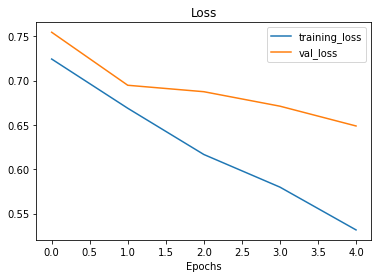

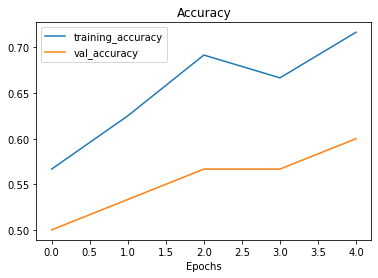

In [81]:
# Plot loss curves
plot_loss_curves(history_1)

# Fine - Tune and existing model

In [82]:
# To begin fine-tuning,let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (Since we made a change)
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.0001),# When fine-tuning, typically we lower the lr by 10x*
    metrics = ['accuracy']
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [84]:
# Check which layers are trainable
for layer_number,layer in enumerate(model_1.layers[2].layers):
  print(layer_number,layer.name,)

0 input_5
1 rescaling_4
2 normalization_4
3 tf.math.truediv_4
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [86]:
# How many trainable variables?
print(len(model_1.trainable_variables))

12


In [87]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs+5

# Refit the model (same as model_2 except with more trainable layers)
history_1_fine_tune = model_1.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps = int(len(test_data)),
                        initial_epoch=history_1.epoch[-1], #start training form previous last epoch
                        callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                 experiment_name='skin_disease_fine_tune_last_10')]
                        )

Saving TensorBoard log files to: transfer_learning/skin_disease_fine_tune_last_10/20230131-024835
Epoch 5/10
4/4 [==============================] - 20s 3s/step - loss: 0.4960 - accuracy: 0.7667 - val_loss: 0.6150 - val_accuracy: 0.7000
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 0.4494 - accuracy: 0.7833 - val_loss: 0.6762 - val_accuracy: 0.6667
Epoch 7/10
4/4 [==============================] - 12s 2s/step - loss: 0.4073 - accuracy: 0.8333 - val_loss: 0.7403 - val_accuracy: 0.6000
Epoch 8/10
4/4 [==============================] - 11s 2s/step - loss: 0.3682 - accuracy: 0.8833 - val_loss: 0.7292 - val_accuracy: 0.5667
Epoch 9/10
4/4 [==============================] - 13s 3s/step - loss: 0.3477 - accuracy: 0.8750 - val_loss: 0.6876 - val_accuracy: 0.6667
Epoch 10/10
4/4 [==============================] - 12s 3s/step - loss: 0.3563 - accuracy: 0.8500 - val_loss: 0.6958 - val_accuracy: 0.6667


In [88]:
# Evaluate the fine-tuned model
results_fine_tune_skin_diseases = model_1.evaluate(test_data)

1/1 [==============================] - 3s 3s/step - loss: 0.6958 - accuracy: 0.6667


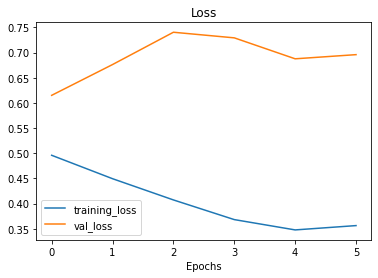

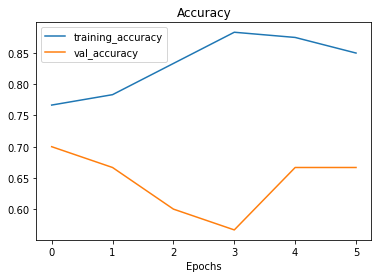

In [89]:
# Check loss curves
plot_loss_curves(history_1_fine_tune)

In [90]:
# Let's create a function to compare training histrories
def compare_histories(original_history,new_history,initial_epochs=5):
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label='Training Accuracy')
  plt.plot(total_val_acc,label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label='Training Loss')
  plt.plot(total_val_loss,label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

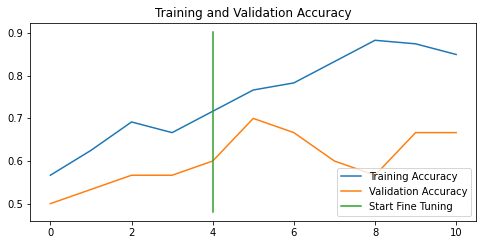

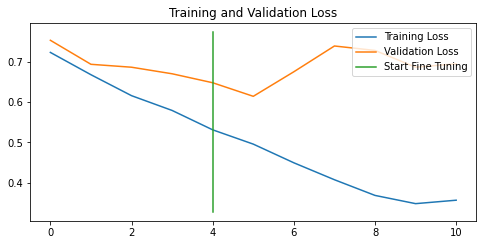

In [91]:
compare_histories(history_1,history_1_fine_tune)